# Principal Component Kalman Filter

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import PCA

In [3]:
df_fut = (pd.read_parquet(
    path = "TreasuryFutures.parquet", engine = "pyarrow"))

In [4]:
df_wider = (df_fut[
    ["date", "security", "PX_LAST"]].
    pivot(index = "date", columns = "security", values = "PX_LAST").
    fillna(0))

In [5]:
n_comps = 3

df_pca = pd.DataFrame(
    data    = PCA(n_components = n_comps).fit_transform(df_wider),
    columns = ["PC{}".format(i + 1) for i in range(n_comps)],
    index   = df_wider.index)

array([[<Axes: xlabel='date'>, <Axes: xlabel='date'>,
        <Axes: xlabel='date'>]], dtype=object)

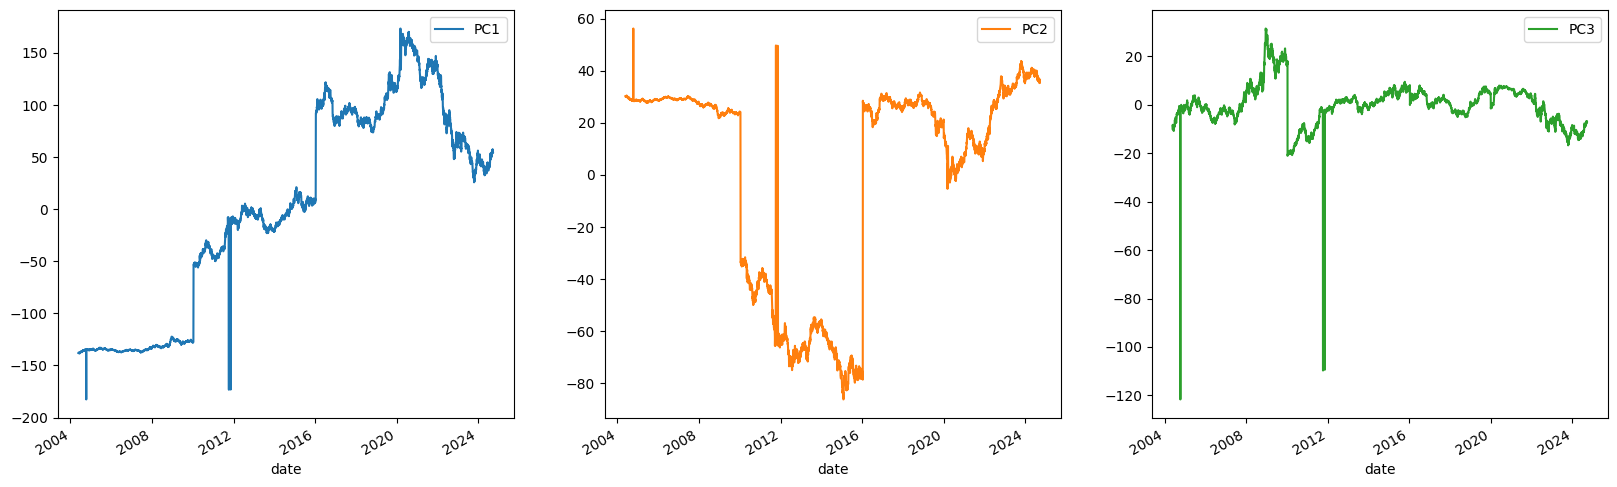

In [6]:
df_pca.plot(subplots = True, layout = (1,3), figsize = (20,6))

        df_tmp        = df.sort_values("date").dropna()
        kalman_filter = KalmanFilter(
            transition_matrices      = [1],
            observation_matrices     = [1],
            initial_state_mean       = 0,
            initial_state_covariance = 1,
            observation_covariance   = 1,
            transition_covariance    = 0.01)
        
        state_means, state_covariances = kalman_filter.filter(df_tmp.value)
        df_out = (df_tmp.assign(
            smooth     = state_means,
            lag_smooth = lambda x: x.smooth.shift(),
            resid      = lambda x: x.lag_smooth - x.value,
            lag_resid  = lambda x: x.resid.shift()).
            drop(columns = ["value"]))

In [7]:
!pip install pykalman
from pykalman import KalmanFilter

In [8]:
def _get_kalman(df: pd.DataFrame) -> pd.DataFrame:

    df_tmp        = df.sort_values("date").dropna()
    kalman_filter = KalmanFilter(
        transition_matrices      = [1],
        observation_matrices     = [1],
        initial_state_mean       = 0,
        initial_state_covariance = 1,
        observation_covariance   = 1,
        transition_covariance    = 0.01)

    state_means, state_covariances = kalman_filter.filter(df_tmp.value)
    df_out = (df_tmp.assign(
        smooth     = state_means,
        lag_smooth = lambda x: x.smooth.shift(),
        resid      = lambda x: x.lag_smooth - x.value,
        lag_resid  = lambda x: x.resid.shift()).
        drop(columns = ["value"]))

    return df_out

df_kalman = (df_pca.reset_index().melt(
    id_vars = "date").
    groupby("variable").
    apply(_get_kalman).
    reset_index(drop = True))

<ipython-input-8-7748ad0db0f1>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(_get_kalman).


In [9]:
def _get_zscore(df: pd.DataFrame, window: int) -> pd.DataFrame:

    df_out = (df.sort_values(
        "date").
        assign(
            roll_mean  = lambda x: x.lag_resid.ewm(span = window, adjust = False).mean(),
            roll_std   = lambda x: x.lag_resid.ewm(span = window, adjust = False).std(),
            z_score    = lambda x: (x.lag_resid - x.roll_mean) / x.roll_std,
            lag_zscore = lambda x: x.z_score.shift()))

    return df_out

window: int = 5

df_zscore = (df_kalman.dropna().groupby(
    "variable").
    apply(_get_zscore, window).
    reset_index(drop = True))

<ipython-input-9-00e2a7cd309d>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(_get_zscore, window).


In [10]:
df_signal_rtn = (df_zscore[
    ["date", "variable", "lag_zscore"]].
    dropna().
    merge(right = df_fut, how = "inner", on = ["date"]).
    assign(signal_rtn = lambda x: np.sign(x.lag_zscore) * x.PX_bps).
    assign(signal_rtn = lambda x: np.where(x.variable == "PC2", -1 * x.signal_rtn, x.signal_rtn)))

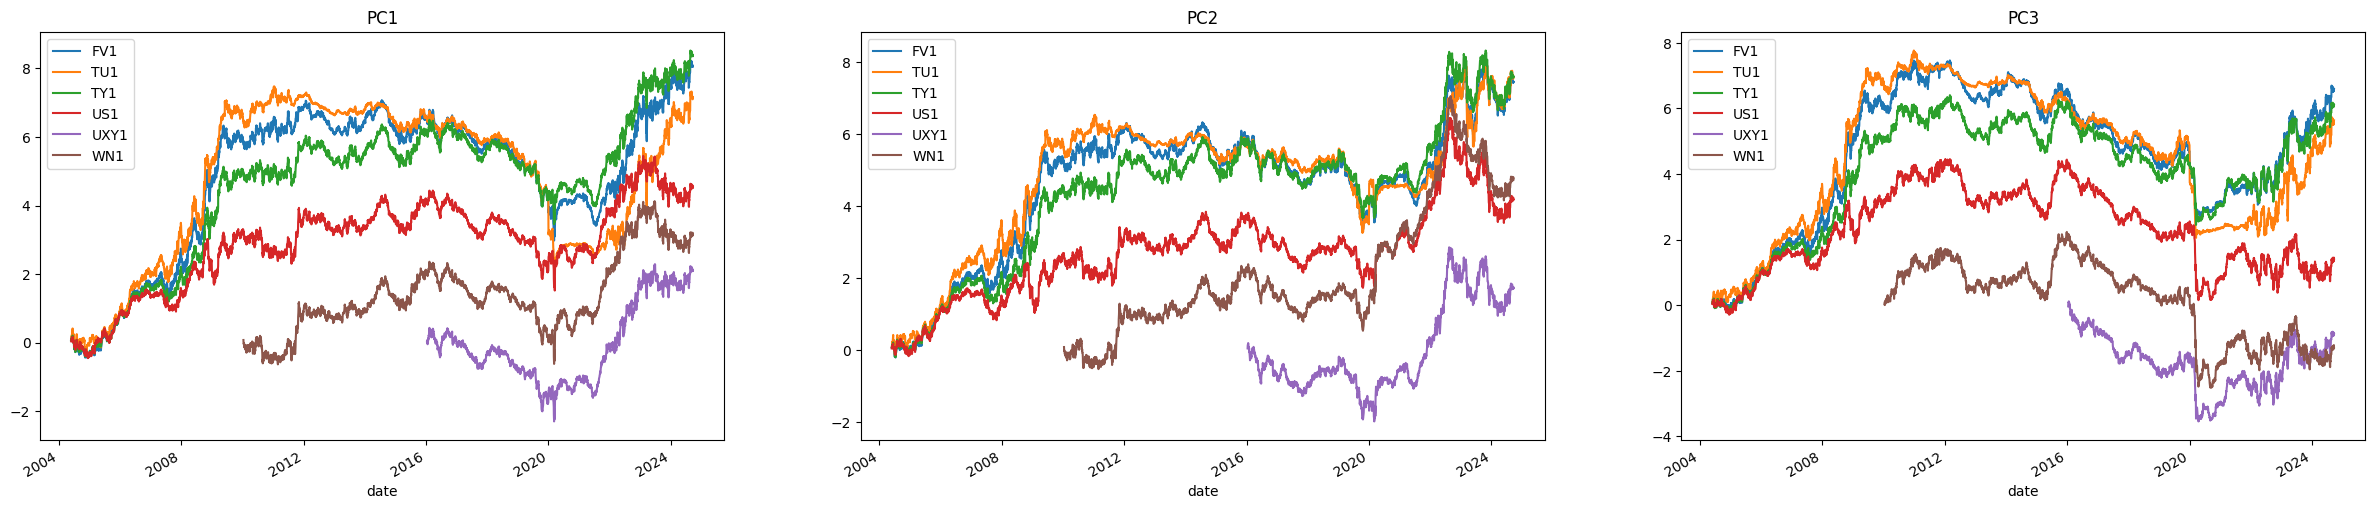

In [11]:
variables = df_signal_rtn.variable.drop_duplicates().sort_values().to_list()
fig, axes = plt.subplots(ncols = len(variables), figsize = (30,6))

for variable, ax in zip(variables, axes.flatten()):

    (df_signal_rtn.query(
        "variable == @variable")
        [["date", "security", "signal_rtn"]].
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        rename(columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        cumsum().
        plot(
            ax    = ax,
            title = variable))

In [12]:
df_sharpe = (df_signal_rtn[
    ["variable", "security", "signal_rtn"]].
    groupby(["variable", "security"]).
    agg(["mean", "std"])
    ["signal_rtn"].
    rename(columns = {
        "mean": "mean_rtn",
        "std" : "std_rtn"}).
    assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
    reset_index().
    assign(security = lambda x: x.security.str.split(" ").str[0]))

array([[<Axes: title={'center': 'PC1'}, xlabel='security'>,
        <Axes: title={'center': 'PC2'}, xlabel='security'>,
        <Axes: title={'center': 'PC3'}, xlabel='security'>]], dtype=object)

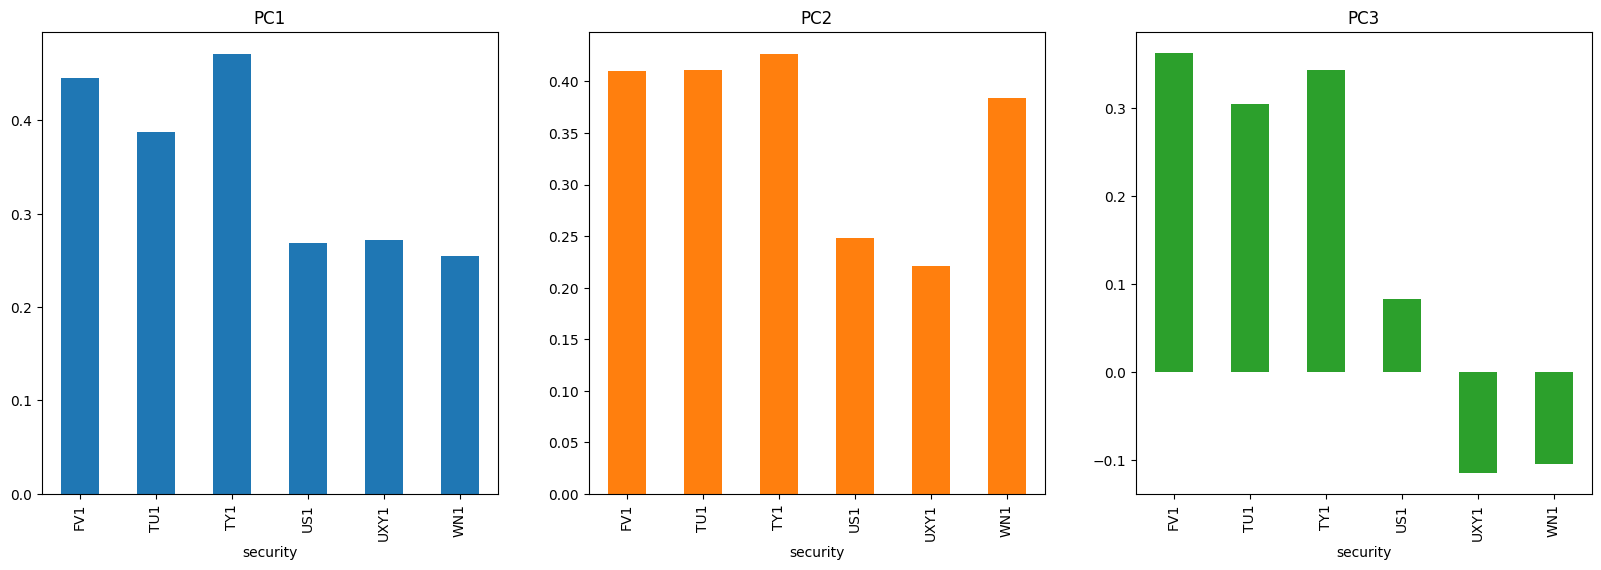

In [13]:
(df_sharpe[
    ["security", "variable", "sharpe"]].
    pivot(index = "security", columns = "variable", values = "sharpe").
    plot(
        legend   = False,
        kind     = "bar",
        subplots = True,
        layout   = (1,3),
        figsize  = (20,6)))

In [14]:
def _get_vol(df: pd.DataFrame, window: int) -> pd.DataFrame:

    df_out = (df.sort_values(
        "date").
        assign(
            roll_vol = lambda x: x.signal_rtn.rolling(window = window).std(),
            lag_vol  = lambda x: x.roll_vol.shift()))

    return df_out

window: int = 30

df_vol = (df_signal_rtn[
    ["date", "variable", "security", "signal_rtn"]].
    groupby(["variable", "security"]).
    apply(_get_vol, window).
    reset_index(drop = True).
    dropna().
    assign(inv_vol = lambda x: 1 / x.lag_vol))

<ipython-input-14-b7a2e5c13429>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(_get_vol, window).


In [15]:
df_erc_pc = (df_vol[
    ["date", "variable", "inv_vol"]].
    groupby(["date", "variable"]).
    agg("sum").
    rename(columns = {"inv_vol": "cum_vol"}).
    merge(right = df_vol, how = "inner", on = ["date", "variable"]).
    assign(weighted_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_rtn)
    [["date", "variable", "weighted_rtn"]].
    groupby(["date", "variable"]).
    agg("sum").
    reset_index())

<Axes: xlabel='date'>

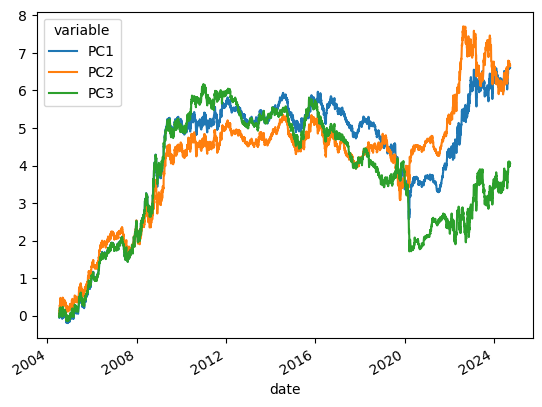

In [16]:
(df_erc_pc.pivot(
    index = "date", columns = "variable", values = "weighted_rtn").
    cumsum().
    plot())

<Axes: xlabel='variable'>

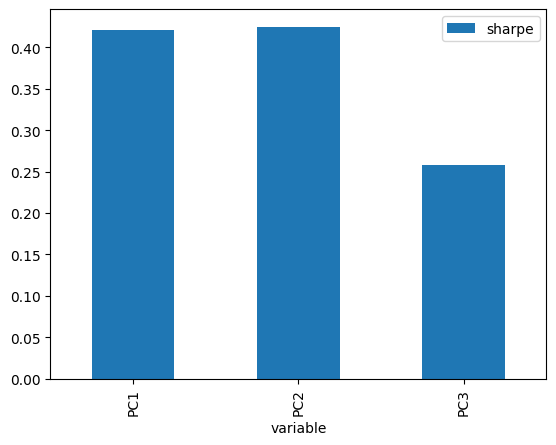

In [17]:
(df_erc_pc.drop(
    columns = ["date"]).
    groupby("variable").
    agg(["mean", "std"])
    ["weighted_rtn"].
    rename(columns = {
        "mean": "mean_rtn",
        "std" : "std_rtn"}).
    assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
    [["sharpe"]].
    plot(kind = "bar"))

In [18]:
df_erc_fut = (df_vol[
    ["date", "security", "inv_vol"]].
    groupby(["date", "security"]).
    agg("sum").
    rename(columns = {"inv_vol": "cum_vol"}).
    reset_index().
    merge(right = df_vol, how = "inner", on = ["date", "security"]).
    assign(weighted_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_rtn)
    [["date", "security", "weighted_rtn"]].
    groupby(["date", "security"]).
    agg("sum").
    reset_index())

<Axes: xlabel='date'>

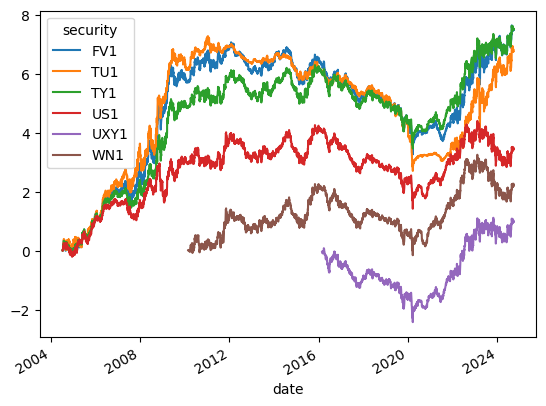

In [19]:
(df_erc_fut.assign(
    security = lambda x: x.security.str.split(" ").str[0]).
    pivot(index = "date", columns = "security", values = "weighted_rtn").
    cumsum().
    plot())

<Axes: xlabel='security'>

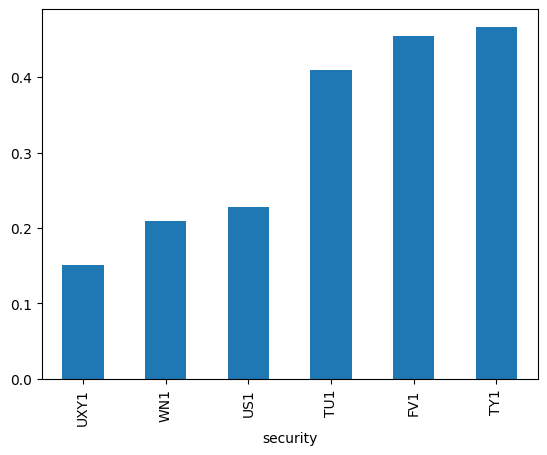

In [20]:
(df_erc_fut.drop(
    columns = ["date"]).
    assign(security = lambda x: x.security.str.split(" ").str[0]).
    groupby("security").
    agg(["mean", "std"])
    ["weighted_rtn"].
    rename(columns = {
        "mean": "mean_rtn",
        "std" : "std_rtn"}).
    assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
    [["sharpe"]].
    sort_values("sharpe").
    plot(
        kind   = "bar",
        legend = False))